# Predicting whether passenger was transported to an alternate dimension

This project looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether or not someone was transported to an alternate dimension based on various data like whether they were in cryo sleep or from what destination they were flying.

### Motivation

Main motivation was taking part in Kaggle's competition. Description from Kaggle's page: 
> "In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system."

Following approach will be used:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

## 1. Problem definition

In a statement,
> Given personal records about a passenger, can I predict whether or not they were transported to another dimension?

## 2. Data

The data came from the ship's damaged computer system. More importantly, from Kaggle's competition page:
https://www.kaggle.com/competitions/spaceship-titanic/data

## 3. Evaluation

Main metric used will be accuracy due to class balance.
> The goal is achieving 80% accuracy. Accuracy above 90% is most likely only achievable with neural networks

## 4. Features

**Data dictionary**

1. `PassengerId` - A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. People in a group are often family members, but not always.
2. `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
3. `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
4. `Cabin` - The cabin number where the passenger is staying. Takes the form `deck/num/side`, where side can be either `P` for Port or `S` for Starboard.
5. `Destination` - The planet the passenger will be debarking to.
6. `Age` - The age of the passenger.
7. `VIP` - Whether the passenger has paid for special VIP service during the voyage.
8. `RoomService`, 9. `FoodCourt`, 10. `ShoppingMall`, 11. `Spa`, 12. `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
13. `Name` - The first and last names of the passenger.
14. `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

## Preparing the tools

I am going to use pandas, Matplotlib and NumPy for data analysis and manipulation.

In [17]:
# Import all the tools I need

# For timing training times
import time

# For saving and loading models
import pickle

# Regular EDA (exploratory data analysis) and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

# Preprocessing tools
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

## Load data

In [64]:
df = pd.read_csv("data/train.csv")
df.shape # (rows, columns)

(8693, 14)

In [3]:
df.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


## Data Exploration

Firstly let's take a look whether classes are really balanced.

In [4]:
df['Transported'].value_counts(normalize=True)

True     0.503624
False    0.496376
Name: Transported, dtype: float64

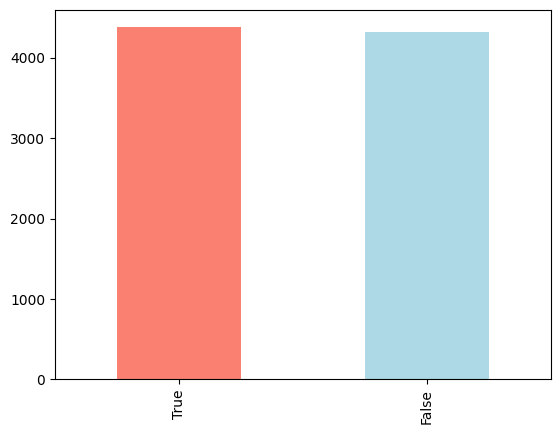

In [5]:
df["Transported"].value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

As mentioned above classes are balanced

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [8]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

No missing values in `Transported` column, that is good.

### Dropping Name column

`Name` column is redundant, and doesn't bring anything new.

`PassengerId` column already gives data related to whether passengers travelled together or not.

In [65]:
df.drop(columns="Name", inplace=True)
df.shape

(8693, 13)

`PassengerId` is interesting column, it gives information about groups of travellers, which could prove useful. In order for this column to be useful the individual id needs to be removed. `PassengerId` needs to be transformed from `gggg_pp` to `gggg`

In [66]:
df['GroupNumber'] = df['PassengerId'].str.split('_').str[0]
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNumber
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004


In [67]:
df.drop(columns="PassengerId", inplace=True)
df.shape

(8693, 13)

### Cabin column transformation
`Cabin` - The cabin number where the passenger is staying. Takes the form `deck/num/side`, where side can be either `P` for Port or `S` for Starboard.

I believe the best way to handle this column is to split it into 2 columns. `num` column is redundant due to existence of `GroupNumber` column.

In [68]:
df['Deck'] = df['Cabin'].str.split('/').str[0]
df['Side'] = df['Cabin'].str.split('/').str[2]
df.head(10)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNumber,Deck,Side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,B,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,F,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,A,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,A,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,F,S
5,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,True,0005,F,P
6,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,True,0006,F,S
7,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,True,0006,G,S
8,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,True,0007,F,S
9,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,True,0008,B,P


In [69]:
df.shape

(8693, 15)

In [8]:
df.head(10)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNumber,Deck,Side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,B,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,F,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,A,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,A,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,F,S
5,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,True,0005,F,P
6,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,True,0006,F,S
7,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,True,0006,G,S
8,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,True,0007,F,S
9,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,True,0008,B,P


In [70]:
df.drop(columns="Cabin", inplace=True)
df.shape

(8693, 14)

### Back to EDA

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   bool   
 11  GroupNumber   8693 non-null   object 
 12  Deck          8494 non-null   object 
 13  Side          8494 non-null   object 
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [17]:
df['Deck'].value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Deck, dtype: int64

`Deck` column has 8 different possible values that are spread out unevenly.

In [18]:
df['Side'].value_counts()

S    4288
P    4206
Name: Side, dtype: int64

`Side` column has 2 different possible values that are spread evenly.

Let's look at statistics of numerical data.

In [19]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


* `Age` starts at 0 and ends on 79.
* Not a lot of people paid for `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa` and `VRDeck`.

### Numerical data

Let's visualize numerical data features.

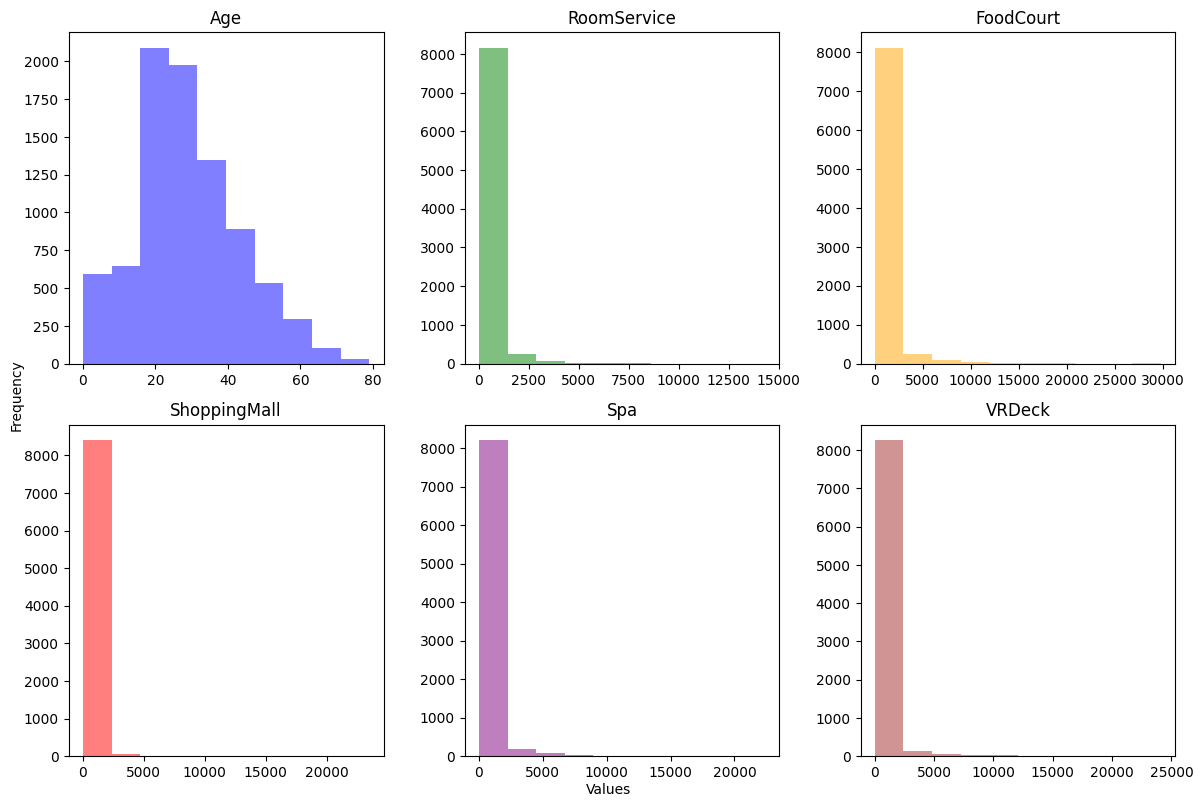

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))  # Create a 2x3 grid of subplots

# Plot histograms for each feature
ax[0, 0].hist(df['Age'], bins=10, color='blue', alpha=0.5)
ax[0, 0].set_title('Age')

ax[0, 1].hist(df['RoomService'], bins=10, color='green', alpha=0.5)
ax[0, 1].set_title('RoomService')

ax[0, 2].hist(df['FoodCourt'], bins=10, color='orange', alpha=0.5)
ax[0, 2].set_title('FoodCourt')

ax[1, 0].hist(df['ShoppingMall'], bins=10, color='red', alpha=0.5)
ax[1, 0].set_title('ShoppingMall')

ax[1, 1].hist(df['Spa'], bins=10, color='purple', alpha=0.5)
ax[1, 1].set_title('Spa')

ax[1, 2].hist(df['VRDeck'], bins=10, color='brown', alpha=0.5)
ax[1, 2].set_title('VRDeck')

# Set a common x-axis label and y-axis label
fig.text(0.5, 0.001, 'Values', ha='center')
fig.text(0.001, 0.5, 'Frequency', va='center', rotation='vertical')

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()  # Display the figure

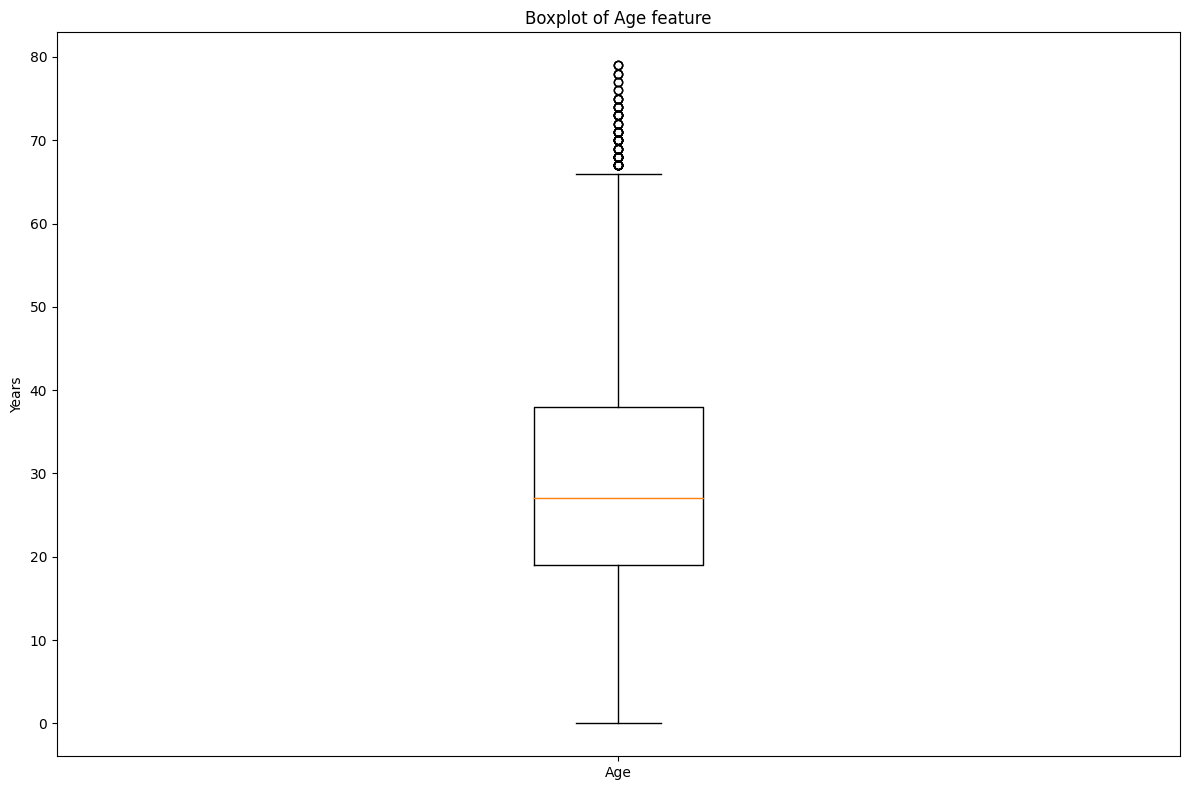

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))

# Create boxplot of Age without missing values that normally would be in Age column
ax.boxplot(df[df['Age'].notnull()]['Age'])
ax.set_xticklabels(['Age']) # Set x label
ax.set(title="Boxplot of Age feature", ylabel="Years") # Set title and label
plt.tight_layout()  # Adjust the spacing between subplots

plt.show()  # Display the figure

Looks like `Age` column is spread out as expected.

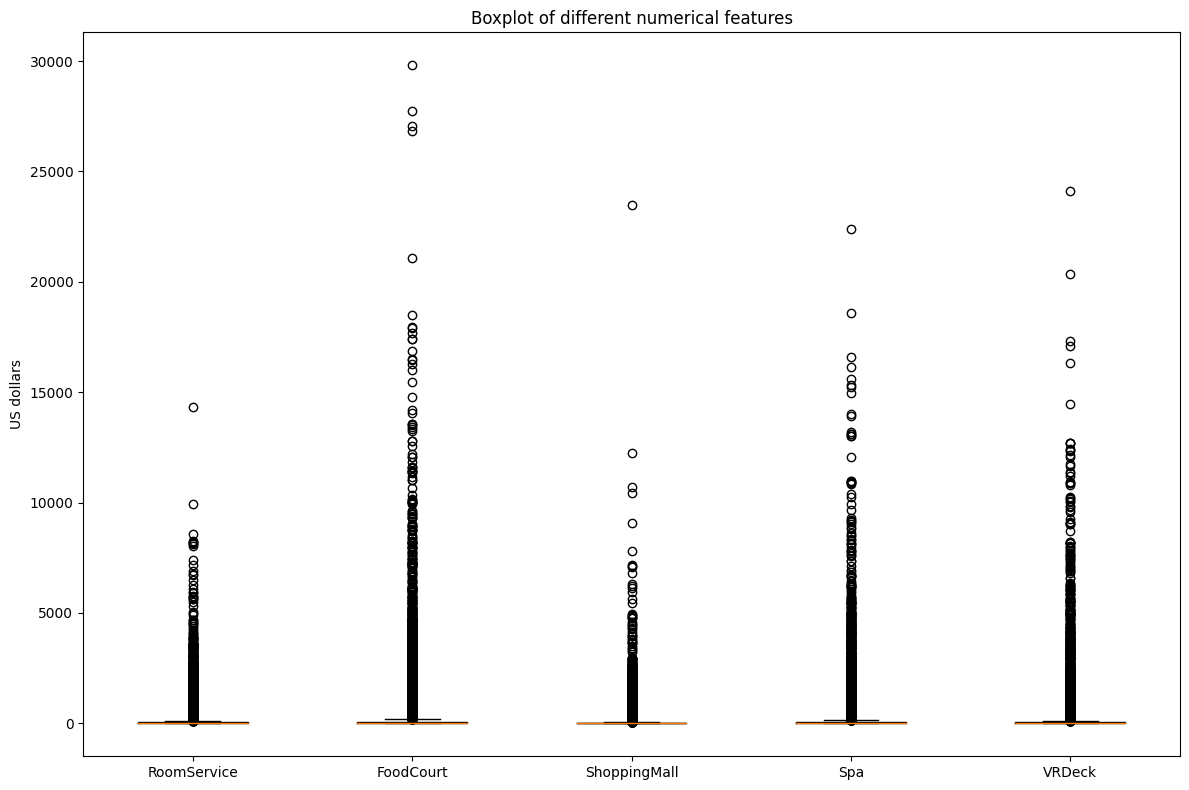

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))

# Create boxplots on one figure of different numerical features (excluding missing values)
ax.boxplot([df[df['RoomService'].notnull()]['RoomService'], 
            df[df['FoodCourt'].notnull()]['FoodCourt'], 
            df[df['ShoppingMall'].notnull()]['ShoppingMall'], 
            df[df['Spa'].notnull()]['Spa'], 
            df[df['VRDeck'].notnull()]['VRDeck']])

# Set titles and labels
ax.set(title="Boxplot of different numerical features", ylabel="US dollars")
ax.set_xticklabels(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()  # Display the figure

As we can see there are a lot of outliers. This will have an impact later on, for example when choosing normalizers.

### Categorical data

Let's start by creating bar plots visualizing frequency of each category

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   bool   
 11  GroupNumber   8693 non-null   object 
 12  Deck          8494 non-null   object 
 13  Side          8494 non-null   object 
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [24]:
df.head(1)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNumber,Deck,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,B,P


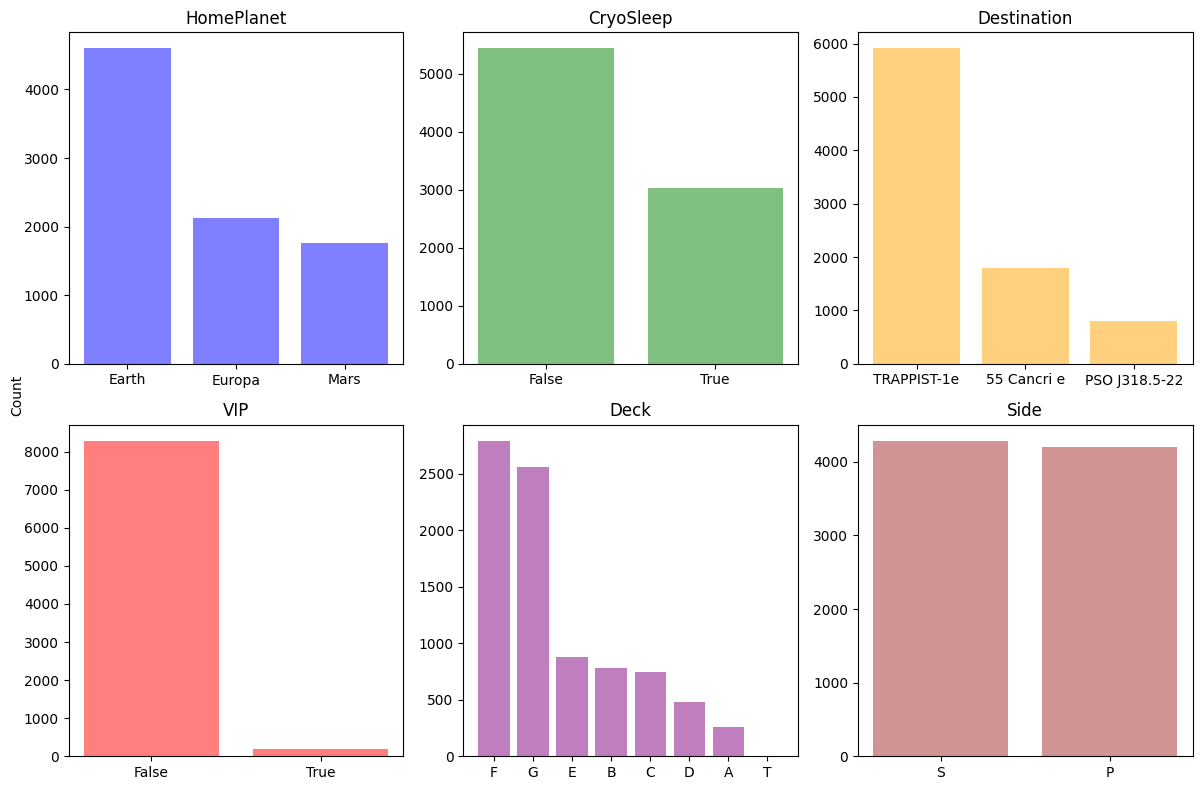

In [25]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))  # Create a 2x3 grid of subplots

# Plot bar plots for each categorical feature (excluding GroupNumber)
ax[0, 0].bar(df['HomePlanet'].value_counts().index, 
             df['HomePlanet'].value_counts().values, color='blue', alpha=0.5)
ax[0, 0].set_title('HomePlanet')

ax[0, 1].bar(['False', 'True'], 
             df['CryoSleep'].value_counts().values, color='green', alpha=0.5)
ax[0, 1].set_title('CryoSleep')

ax[0, 2].bar(df['Destination'].value_counts().index, 
             df['Destination'].value_counts().values, color='orange', alpha=0.5)
ax[0, 2].set_title('Destination')

ax[1, 0].bar(['False', 'True'], 
             df['VIP'].value_counts().values, color='red', alpha=0.5)
ax[1, 0].set_title('VIP')

ax[1, 1].bar(df['Deck'].value_counts().index, 
             df['Deck'].value_counts().values, color='purple', alpha=0.5)
ax[1, 1].set_title('Deck')

ax[1, 2].bar(df['Side'].value_counts().index, 
             df['Side'].value_counts().values, color='brown', alpha=0.5)
ax[1, 2].set_title('Side')

fig.text(0.001, 0.5, 'Count', va='center', rotation='vertical') # Set y label for all plots
plt.tight_layout()  # Adjust the spacing between subplots

plt.show()  # Display the figure

Looking at `VIP` column, small amount of people decided to be a `VIP`.

Same applies to people staying at deck `T`.

In [26]:
df['GroupNumber'].value_counts()

4498    8
8168    8
8728    8
8796    8
8956    8
       ..
3483    1
3480    1
3478    1
3473    1
4620    1
Name: GroupNumber, Length: 6217, dtype: int64

`GroupNumber` is a tricky category since it has over 6000 different posiible values. Despite that it is providing valuable information.

### Visualizing missing data

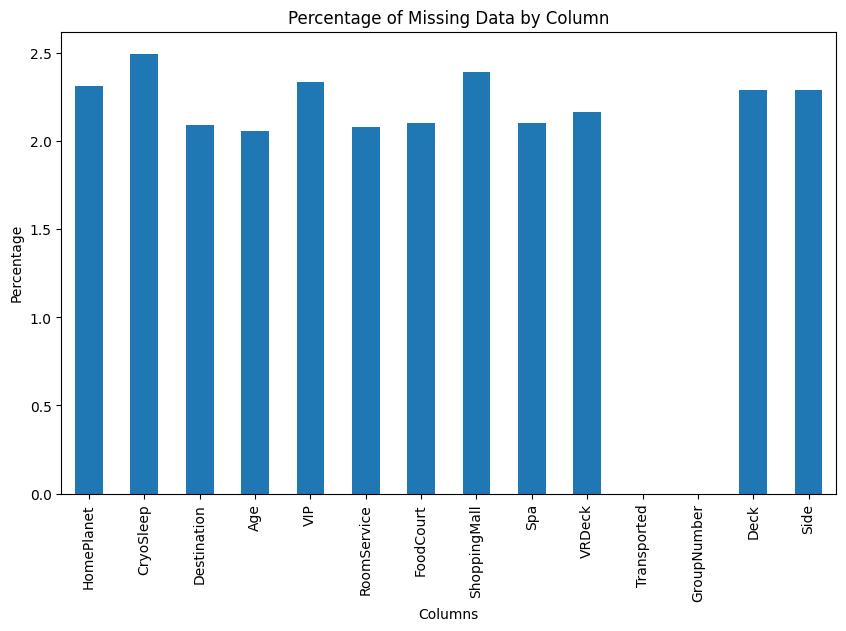

In [27]:
# Take missing data, mean it and transform into percentage
missing_data_percentage = df.isnull().mean() * 100
missing_data_percentage.plot(kind='bar', figsize=(10, 6))

# Set title, x label and y label.
plt.title('Percentage of Missing Data by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.show()

So there is no column that has lots of missing data, that is good.

### Correlation Analysis

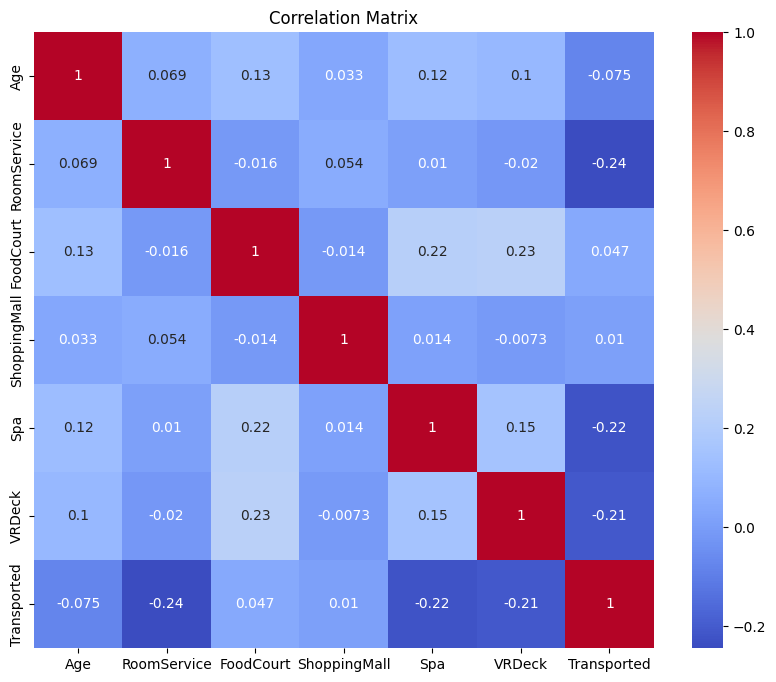

In [28]:
# Create and plot correlation matrix
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Looking at heatmap looks like `RoomService`, `Spa` and `VRDeck` might have some influence on `Transported` target.

Now let's look at categorical features.

In [29]:
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNumber,Deck,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,B,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,F,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,A,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,A,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,F,S


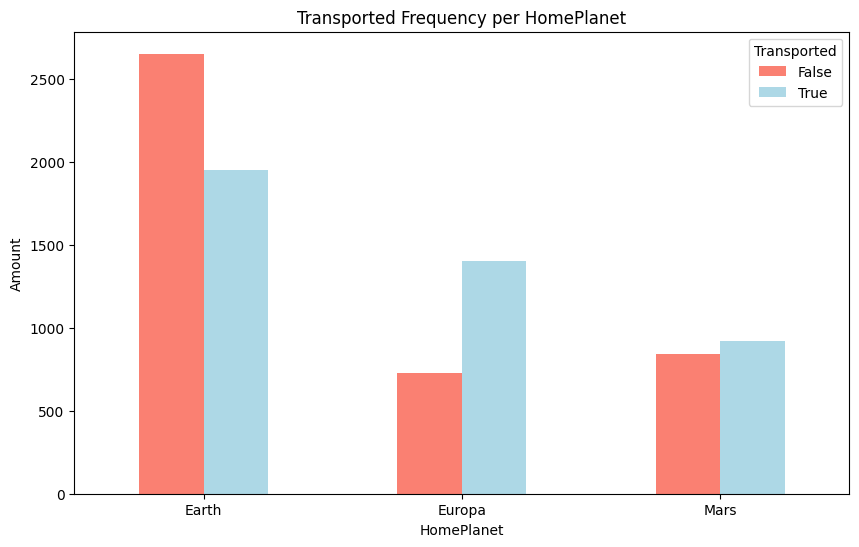

In [30]:
# Create crosstab of target feature and HomePlanet
pd.crosstab(df.HomePlanet, df.Transported).plot(kind="bar", 
                                                figsize=(10,6), 
                                                color=["salmon", "lightblue"])

# Set title and y label
plt.title("Transported Frequency per HomePlanet")
plt.ylabel("Amount")
plt.xticks(rotation=0); # keep the labels on the x-axis vertical

Looking at bar plot looks like if your `HomePlanet` is `Earth` you are less likely to be transported. If your `HomePlanet` is `Europa`, then on the contrary, you are more likely to be transported. And if your `HomePlanet` is `Mars`, it is just as likely to be transported or not.

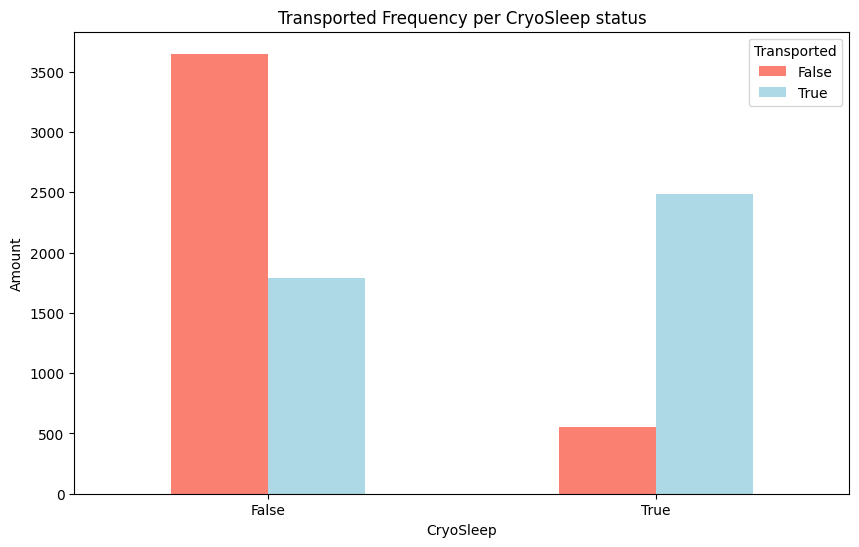

In [31]:
# Create crosstab of target feature and CryoSleep
pd.crosstab(df.CryoSleep, df.Transported).plot(kind="bar", 
                                                figsize=(10,6), 
                                                color=["salmon", "lightblue"])

# Set title and y label
plt.title("Transported Frequency per CryoSleep status")
plt.ylabel("Amount")
plt.xticks(rotation=0); # keep the labels on the x-axis vertical

Now this is interesting. Looks like if you weren't in `CryoSleep` then you are more likely to not be transported. And if you were in `CryoSleep` then you are more likely to be transported.

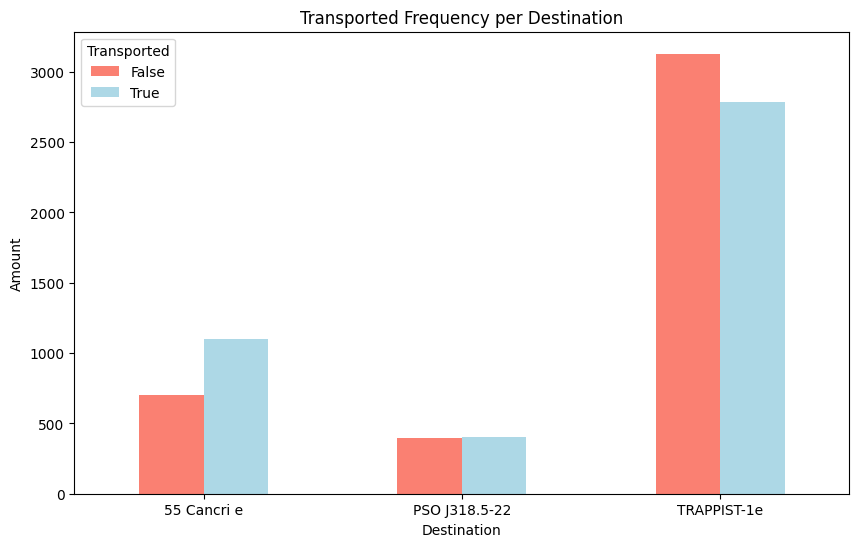

In [32]:
# Create crosstab of target feature and Destination
pd.crosstab(df.Destination, df.Transported).plot(kind="bar", 
                                                figsize=(10,6), 
                                                color=["salmon", "lightblue"])

# Set title and y label
plt.title("Transported Frequency per Destination")
plt.ylabel("Amount")
plt.xticks(rotation=0); # keep the labels on the x-axis vertical

Here it looks like `Destination` doesn't matter that much. It will not be a good predictor for `Transported`.

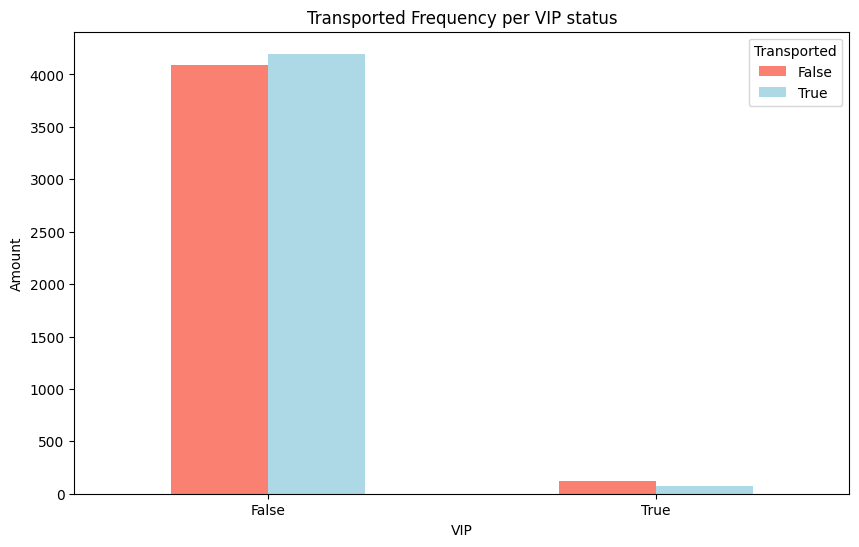

In [33]:
# Create crosstab of target feature and VIP
pd.crosstab(df.VIP, df.Transported).plot(kind="bar", 
                                                figsize=(10,6), 
                                                color=["salmon", "lightblue"])

# Set title and y label
plt.title("Transported Frequency per VIP status")
plt.ylabel("Amount")
plt.xticks(rotation=0); # keep the labels on the x-axis vertical

Similarly to `Destination` - `VIP` doesn't matter that much. It will not be a good predictor for `Transported`.

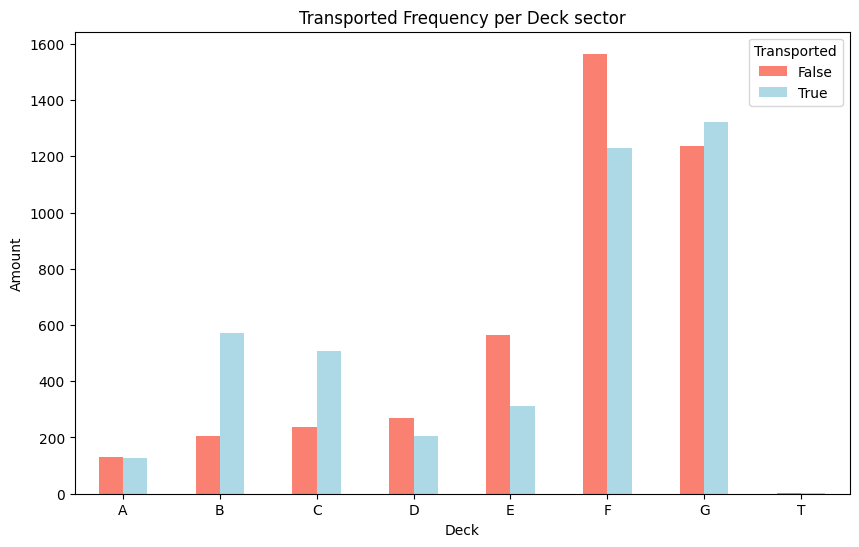

In [34]:
# Create crosstab of target feature and Deck
pd.crosstab(df.Deck, df.Transported).plot(kind="bar", 
                                                figsize=(10,6), 
                                                color=["salmon", "lightblue"])

# Set title and y label
plt.title("Transported Frequency per Deck sector")
plt.ylabel("Amount")
plt.xticks(rotation=0); # keep the labels on the x-axis vertical

People in `Deck` `B` and `C` are much more likely to be transported then people in other decks. On the opposite side, people in `Deck` `E` were less likely to be transported.

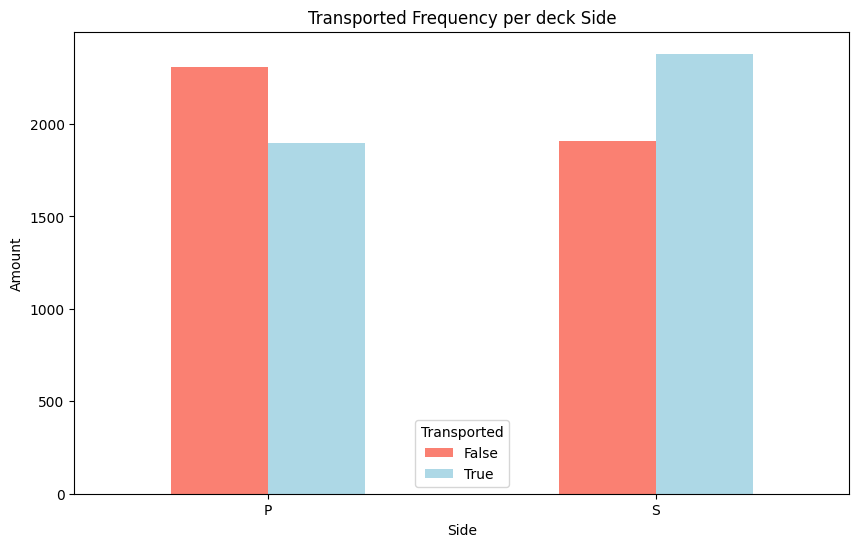

In [35]:
# Create crosstab of target feature and Side
pd.crosstab(df.Side, df.Transported).plot(kind="bar", 
                                                figsize=(10,6), 
                                                color=["salmon", "lightblue"])

# Set title and y label
plt.title("Transported Frequency per deck Side")
plt.ylabel("Amount")
plt.xticks(rotation=0); # keep the labels on the x-axis vertical

Here it looks like `Side` doesn't matter that much. It probably is not a good predictor for `Transported`.

In [10]:
df.head(1)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNumber,Deck,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,B,P


Let's plot some boxplots to better see correlation between target variable and numerical features.

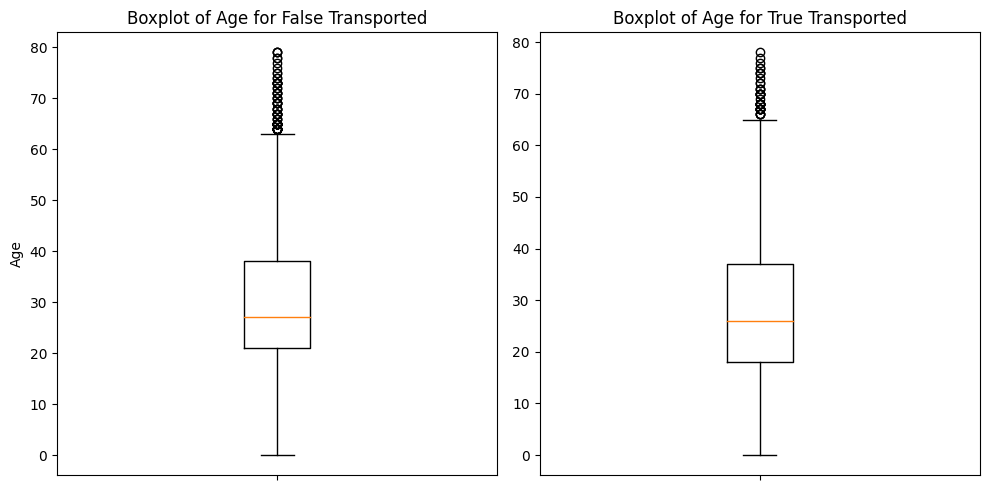

In [37]:
# Create a DataFrame with selected columns
df_selected = df[['Age', 'Transported']]

# Filter the DataFrame for each category of "Transported"
transported_false = df_selected[df_selected['Transported'] == False]
transported_true = df_selected[df_selected['Transported'] == True]

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Create boxplot for "False" in "Transported" column
axes[0].boxplot(transported_false[transported_false['Age'].notnull()]['Age'])
axes[0].set_title('Boxplot of Age for False Transported')
axes[0].set_xticklabels([''])
axes[0].set_ylabel('Age')

# Create boxplot for "True" in "Transported" column
axes[1].boxplot(transported_true[transported_true['Age'].notnull()]['Age'])
axes[1].set_title('Boxplot of Age for True Transported')
axes[1].set_xticklabels([''])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

Here it doesn't look like Age influences whether you can get transported.

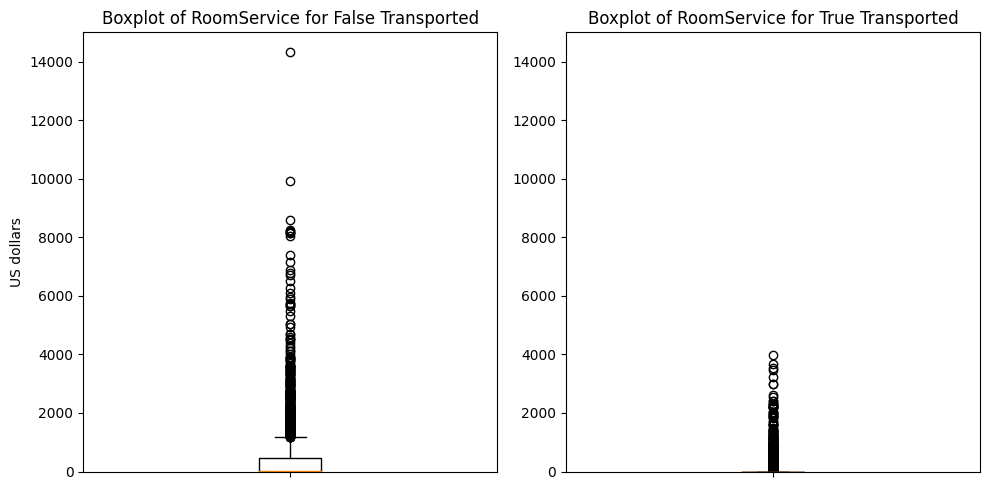

In [38]:
# Create a DataFrame with selected columns
df_selected = df[['RoomService', 'Transported']]

# Filter the DataFrame for each category of "Transported"
transported_false = df_selected[df_selected['Transported'] == False]
transported_true = df_selected[df_selected['Transported'] == True]

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Create boxplot for "False" in "Transported" column
axes[0].boxplot(transported_false[transported_false['RoomService'].notnull()]['RoomService'])
axes[0].set_title('Boxplot of RoomService for False Transported')
axes[0].set_xticklabels([''])
axes[0].set_ylim([0, 15000])
axes[0].set_ylabel('US dollars')

# Create boxplot for "True" in "Transported" column
axes[1].boxplot(transported_true[transported_true['RoomService'].notnull()]['RoomService'])
axes[1].set_title('Boxplot of RoomService for True Transported')
axes[1].set_xticklabels([''])
axes[1].set_ylim([0, 15000])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

Now this shows correlation between spending on RoomService and being transported. Looks like people that spent more were less likely to be transported.

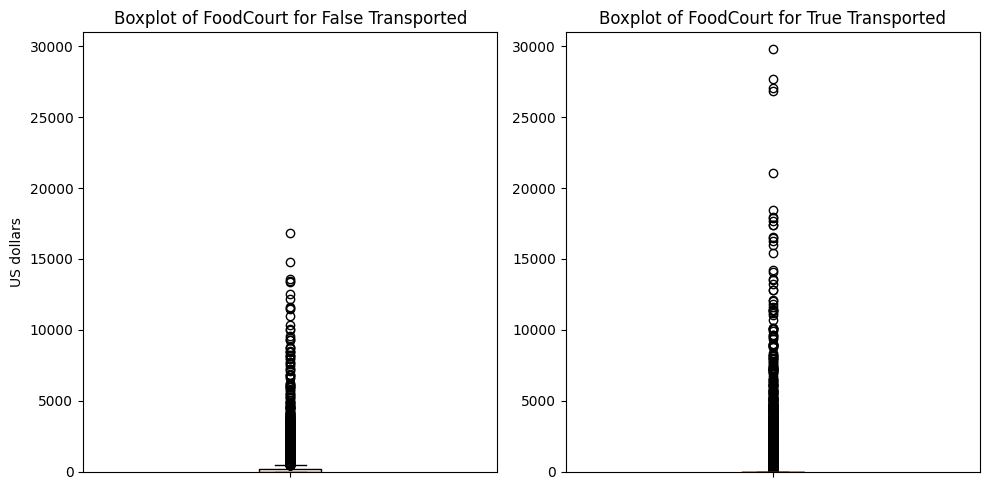

In [39]:
# Create a DataFrame with selected columns
df_selected = df[['FoodCourt', 'Transported']]

# Filter the DataFrame for each category of "Transported"
transported_false = df_selected[df_selected['Transported'] == False]
transported_true = df_selected[df_selected['Transported'] == True]

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Create boxplot for "False" in "Transported" column
axes[0].boxplot(transported_false[transported_false['FoodCourt'].notnull()]['FoodCourt'])
axes[0].set_title('Boxplot of FoodCourt for False Transported')
axes[0].set_xticklabels([''])
axes[0].set_ylim([0, 31000])
axes[0].set_ylabel('US dollars')

# Create boxplot for "True" in "Transported" column
axes[1].boxplot(transported_true[transported_true['FoodCourt'].notnull()]['FoodCourt'])
axes[1].set_title('Boxplot of FoodCourt for True Transported')
axes[1].set_xticklabels([''])
axes[1].set_ylim([0, 31000])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

Here the correlation is not that strong.

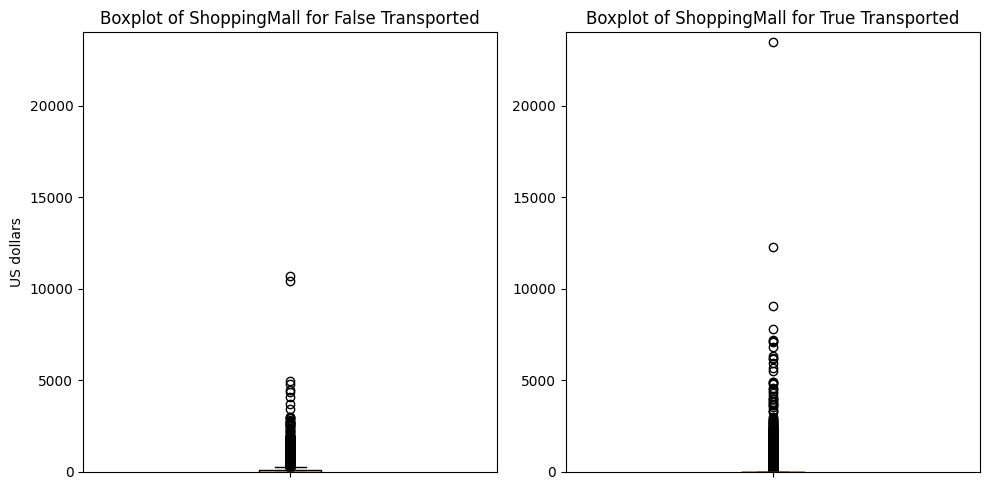

In [40]:
# Create a DataFrame with selected columns
df_selected = df[['ShoppingMall', 'Transported']]

# Filter the DataFrame for each category of "Transported"
transported_false = df_selected[df_selected['Transported'] == False]
transported_true = df_selected[df_selected['Transported'] == True]

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Create boxplot for "False" in "Transported" column
axes[0].boxplot(transported_false[transported_false['ShoppingMall'].notnull()]['ShoppingMall'])
axes[0].set_title('Boxplot of ShoppingMall for False Transported')
axes[0].set_xticklabels([''])
axes[0].set_ylim([0, 24000])
axes[0].set_ylabel('US dollars')

# Create boxplot for "True" in "Transported" column
axes[1].boxplot(transported_true[transported_true['ShoppingMall'].notnull()]['ShoppingMall'])
axes[1].set_title('Boxplot of ShoppingMall for True Transported')
axes[1].set_xticklabels([''])
axes[1].set_ylim([0, 24000])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

Here also correlation is rather small.

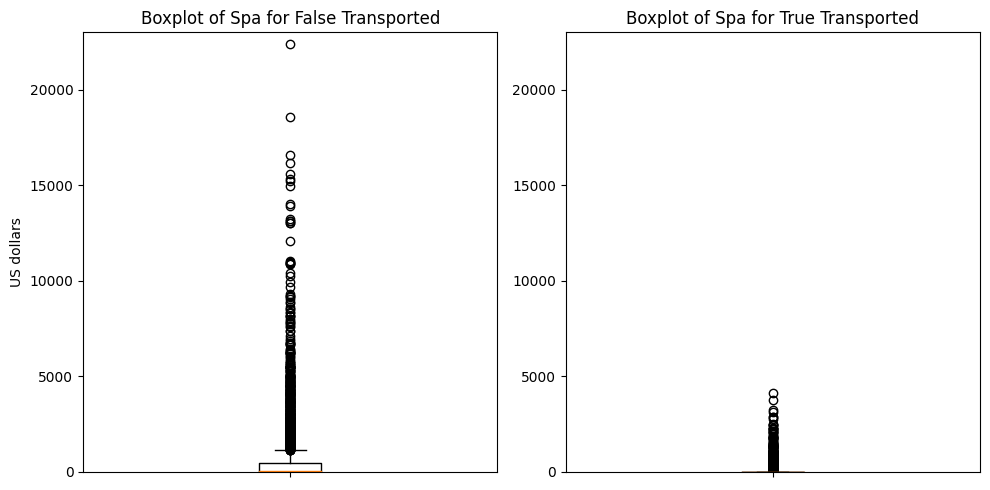

In [41]:
# Create a DataFrame with selected columns
df_selected = df[['Spa', 'Transported']]

# Filter the DataFrame for each category of "Transported"
transported_false = df_selected[df_selected['Transported'] == False]
transported_true = df_selected[df_selected['Transported'] == True]

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Create boxplot for "False" in "Transported" column
axes[0].boxplot(transported_false[transported_false['Spa'].notnull()]['Spa'])
axes[0].set_title('Boxplot of Spa for False Transported')
axes[0].set_xticklabels([''])
axes[0].set_ylim([0, 23000])
axes[0].set_ylabel('US dollars')

# Create boxplot for "True" in "Transported" column
axes[1].boxplot(transported_true[transported_true['Spa'].notnull()]['Spa'])
axes[1].set_title('Boxplot of Spa for True Transported')
axes[1].set_xticklabels([''])
axes[1].set_ylim([0, 23000])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

Here correlation is visible. People that spent more on Spa were less likely to be transported.

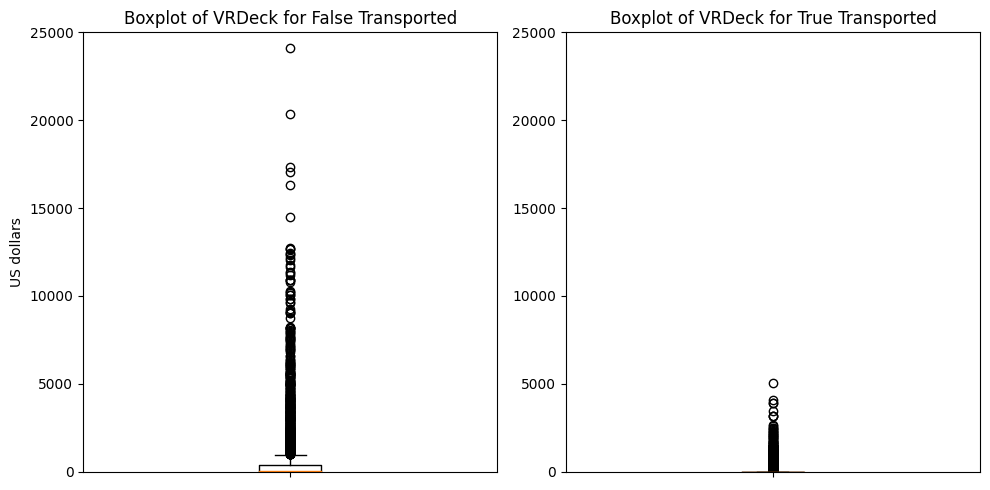

In [42]:
# Create a DataFrame with selected columns
df_selected = df[['VRDeck', 'Transported']]

# Filter the DataFrame for each category of "Transported"
transported_false = df_selected[df_selected['Transported'] == False]
transported_true = df_selected[df_selected['Transported'] == True]

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Create boxplot for "False" in "Transported" column
axes[0].boxplot(transported_false[transported_false['VRDeck'].notnull()]['VRDeck'])
axes[0].set_title('Boxplot of VRDeck for False Transported')
axes[0].set_xticklabels([''])
axes[0].set_ylim([0, 25000])
axes[0].set_ylabel('US dollars')

# Create boxplot for "True" in "Transported" column
axes[1].boxplot(transported_true[transported_true['VRDeck'].notnull()]['VRDeck'])
axes[1].set_title('Boxplot of VRDeck for True Transported')
axes[1].set_xticklabels([''])
axes[1].set_ylim([0, 25000])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

Here, similarly, correlation is visible. People that spent more on VRDeck were less likely to be transported.

In [43]:
df.head(1)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNumber,Deck,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,B,P


Let's see how numerical features are correlated to each other.

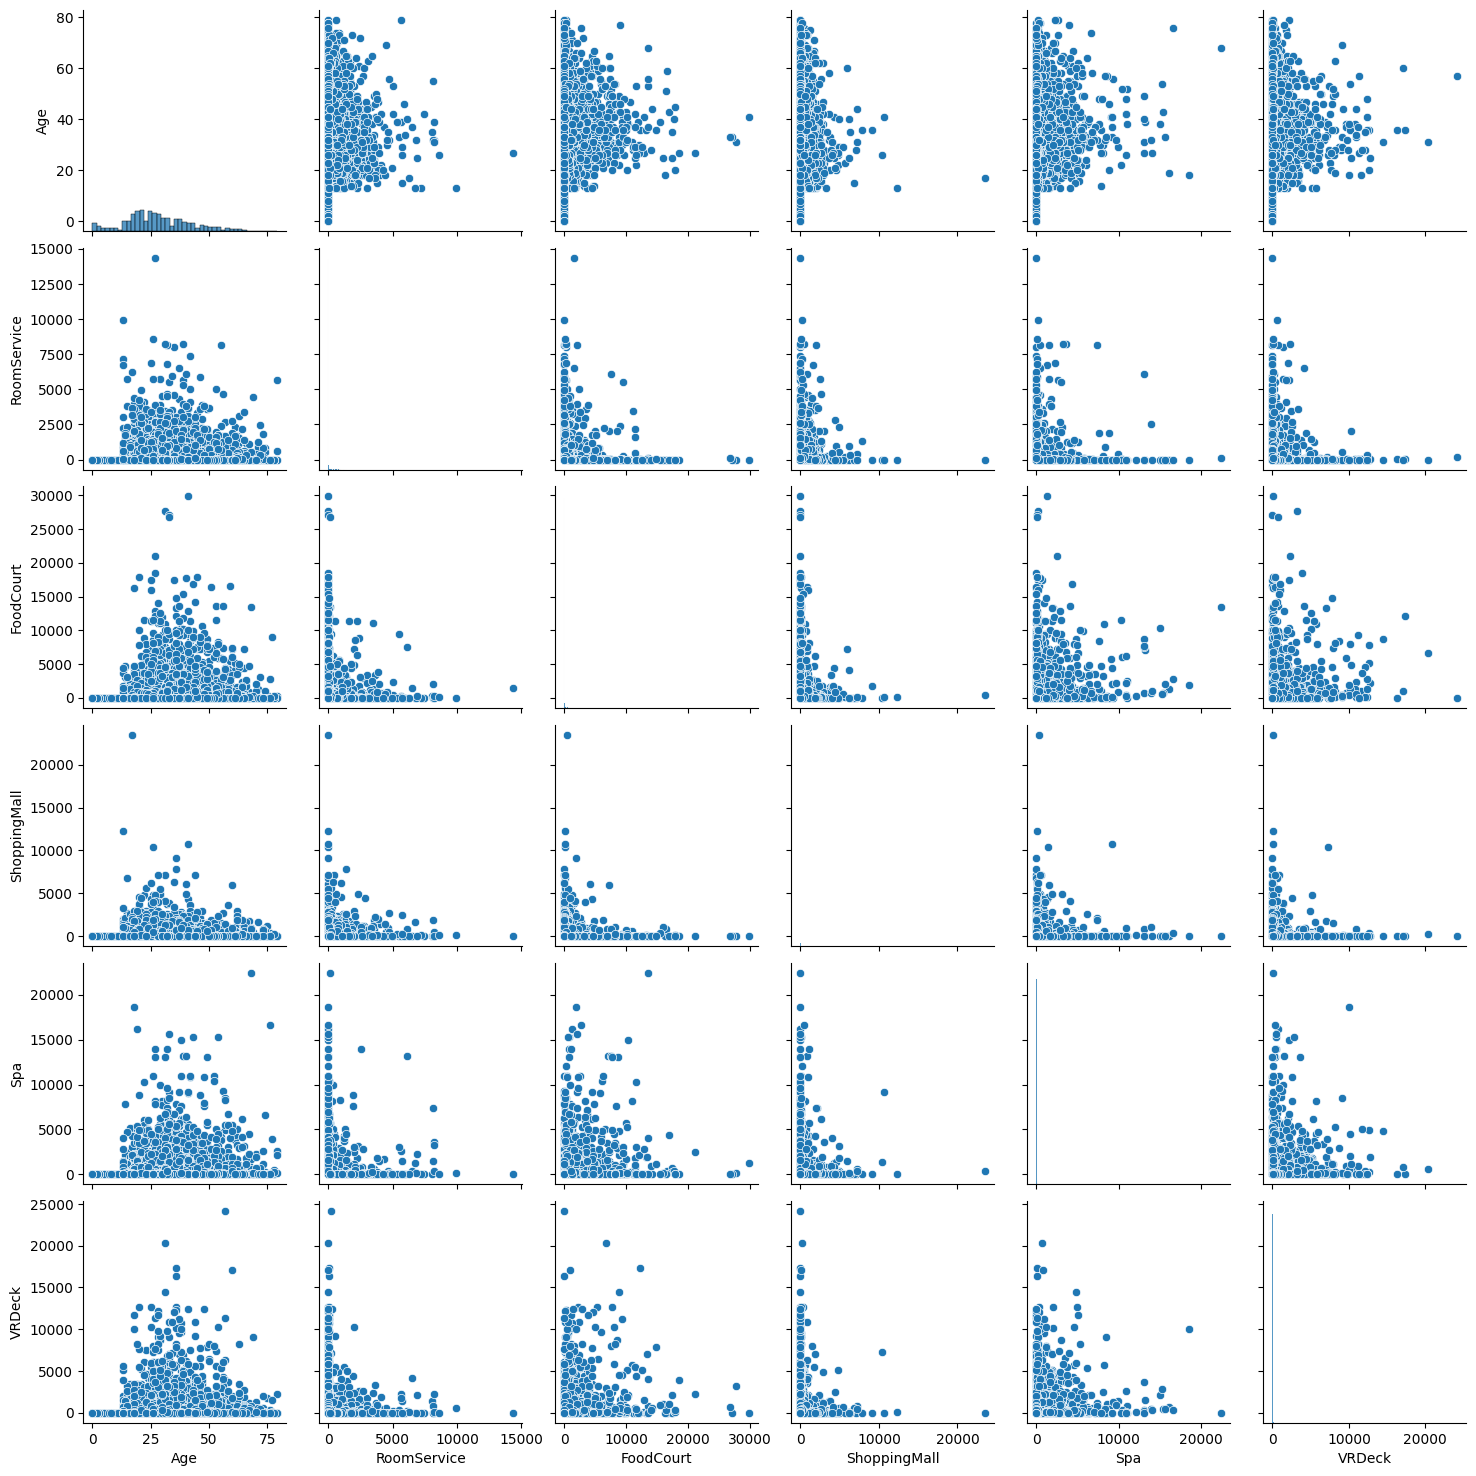

In [44]:
# Select relevant numerical features for the pair plot
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Create a pair plot using seaborn
sns.pairplot(df[numerical_features])
plt.show()

Couple noted examples: 
* Older people tended to spend less on VRDeck and more on Spa.
* People under age of around 18 didn't spend on anything, probably since they couldn't and parents had to spend for them
* Shopping Mall was more popular among younger and middle aged people

### Duplicated rows

Let's check for any duplicated rows

In [45]:
df.duplicated().sum()

9

Looks like there are duplicates in our data. Let's remove them.

In [46]:
df.head(1)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNumber,Deck,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,B,P


In [11]:
df[df.duplicated()]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNumber,Deck,Side
470,Europa,True,55 Cancri e,18.0,False,0.0,0.0,0.0,0.0,0.0,True,0504,B,S
617,Europa,True,55 Cancri e,30.0,False,0.0,0.0,0.0,0.0,0.0,True,0642,C,S
2084,Mars,True,55 Cancri e,20.0,False,0.0,0.0,0.0,0.0,0.0,True,2234,F,P
3027,Europa,True,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0,True,3279,C,S
3276,Earth,True,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,True,3519,G,P
4823,Mars,False,TRAPPIST-1e,4.0,False,0.0,0.0,0.0,0.0,0.0,True,5142,F,P
5450,Mars,True,55 Cancri e,21.0,False,0.0,0.0,0.0,0.0,0.0,True,5814,D,S
7050,Mars,True,TRAPPIST-1e,3.0,False,0.0,0.0,0.0,0.0,0.0,True,7505,F,P
8128,Mars,False,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,0.0,0.0,True,8681,F,P


In [48]:
df.shape

(8693, 14)

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.shape

(8684, 14)

# 5. Modelling

Firstly let's split the data into X and y.

In [14]:
X = df.drop('Transported', axis=1)
y = df['Transported']

In [15]:
X.shape, y.shape

((8684, 13), (8684,))

In [53]:
df.head(1)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNumber,Deck,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,B,P


### Preprocess data

In [16]:
# Define different features and transformer pipelines
categorical_features = ["HomePlanet", 'Destination', 'GroupNumber', 'Deck', 'Side']
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

numeric_features = ["Age", 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), 
    ("scaler", RobustScaler())]) # Good for handling outliers

boolean_features = ['CryoSleep', 'VIP']  # Define boolean features

# Handle missing values for boolean features
boolean_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))])


# Setup preprocessing steps (fill missing values, then convert to numbers)
preprocessor = ColumnTransformer(
                transformers=[
                            ("cat", categorical_transformer, categorical_features),
                            ("num", numeric_transformer, numeric_features), 
                            ("bool", boolean_transformer, boolean_features)])

Models dictionary

In [88]:
# Put models in a dictionary
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier(), 
          "SVM": SVC(), 
          "XGBoost": XGBClassifier()}

In [92]:
# Create function to fit and score models
def models_cross_val(models, X, y, preprocessor):
    """
    Cross validates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X : data without labels
    y : labels assosciated with data
    preprocessor : column transformer constisting of different preprocessing tools
    """
    
    # Random seed for reproducible results
    np.random.seed(42)
    
    # Make a list to keep model scores
    model_scores = {}
        
    # Loop through models
    for name, model in models.items():
        
        # Create a preprocessing and modelling pipeline
        clf_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                        (name, model)])
        
        # Evaluate the model and append its score to model_scores
        model_scores[name] = cross_val_score(clf_pipe, X, y, cv=5, n_jobs=-1).mean()
        
    return model_scores

In [93]:
model_scores = models_cross_val(models, X, y, preprocessor)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8e3a1795a0>
Traceback (most recent call last):
  File "/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignore

In [94]:
model_scores

{'KNN': 0.7683110081739533,
 'Logistic Regression': 0.7863896781622004,
 'Random Forest': 0.7868500433768694,
 'SVM': 0.7885778886739943,
 'XGBoost': 0.7911107264232787}

Let's drop KNN as it is the least appealing classifier for this task.
XGBoost looks like the best for now. Let's try tuning hyperparameters using GridSearchCV and RandomizedSearchCV on 4 best models.

### Logistic Regression

In [104]:
# Create an empty dictionary for storing scores of models
models_best_scores={}

In [107]:
# Create parameter grid for GridSearchCV for LogisticRegression
param_grid = {
    'LogisticRegression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'LogisticRegression__penalty': ['l1', 'l2'],
    'LogisticRegression__solver': ['liblinear', 'saga', 'lbfgs']
}

In [108]:
# Start the timer
start_time = time.time()

# Set the random seed for reproducibility
np.random.seed(42)

# Create pipeline consisting of preprocessing column transformer and model
clf_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                        ("LogisticRegression", LogisticRegression(n_jobs=-1))])

# Setup GridSearchCV
gs_clf = GridSearchCV(estimator=clf_pipe,
                      param_grid=param_grid,
                      cv=5, # 5-fold cross-validation
                      verbose=0)

# Fit the training data to grid search
gs_clf.fit(X, y)

# Find the running time
end_time = time.time()

/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/home/rubic31/repos/spaceship-ti

/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. G

/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/home/rubic31/repos/spaceship-titanic-project/env/lib/python

/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. G

In [109]:
# How long did it take? 
total_time = end_time - start_time
print(f"[INFO] The total running time for running GridSearchCV was {total_time:.2f} seconds.")

[INFO] The total running time for running GridSearchCV was 159.89 seconds.


In [110]:
# Check the best hyperparameters found with GridSearchCV
gs_clf.best_params_

{'LogisticRegression__C': 100,
 'LogisticRegression__penalty': 'l2',
 'LogisticRegression__solver': 'lbfgs'}

In [111]:
# Set up a Logistic Regression model with best parameters
clf_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                        ("LogisticRegression", LogisticRegression(n_jobs=-1, penalty='l2', 
                                                                  C=100, solver='lbfgs'))])

# Cross validate the model
models_best_scores['LogisticRegression'] = cross_val_score(clf_pipe, X, y, 
                                                           cv=5, n_jobs=-1).mean()

/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/rubic31/repos/spaceship-titanic-project/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

In [113]:
models_best_scores

{'LogisticRegression': 0.7904192168816939}

### Random Forest

In [114]:
# Create parameter grid for GridSearchCV for RandomForestClassifier
param_grid = {
    'RandomForest__n_estimators': [100, 300, 500],  # Number of trees in the forest
    'RandomForest__max_depth': [None, 5, 10, 20],  # Maximum depth of the tree
    'RandomForest__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'RandomForest__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'RandomForest__bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

In [115]:
# Start the timer
start_time = time.time()

# Set the random seed for reproducibility
np.random.seed(42)

# Create pipeline consisting of preprocessing column transformer and model
clf_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                        ("RandomForest", RandomForestClassifier(n_jobs=-1))])

# Setup GridSearchCV
gs_clf = GridSearchCV(estimator=clf_pipe,
                      param_grid=param_grid,
                      cv=5, # 5-fold cross-validation
                      verbose=0)

# Fit the training data to grid search
gs_clf.fit(X, y)

# Find the running time
end_time = time.time()

In [116]:
# How long did it take? 
total_time = end_time - start_time
print(f"[INFO] The total running time for running GridSearchCV was {total_time:.2f} seconds.")

[INFO] The total running time for running GridSearchCV was 1192.80 seconds.


In [117]:
# Check the best hyperparameters found with GridSearchCV
gs_clf.best_params_

{'RandomForest__bootstrap': True,
 'RandomForest__max_depth': None,
 'RandomForest__min_samples_leaf': 1,
 'RandomForest__min_samples_split': 5,
 'RandomForest__n_estimators': 500}

In [118]:
# Set up a Random Forest model with best parameters
clf_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                        ("RandomForest", RandomForestClassifier(n_jobs=-1, bootstrap=True, 
                                                                max_depth=None, 
                                                                min_samples_leaf=1, 
                                                                min_samples_split=5, 
                                                                n_estimators=500))])

# Cross validate the model
models_best_scores['RandomForest'] = cross_val_score(clf_pipe, X, y, 
                                                           cv=5, n_jobs=-1).mean()

In [119]:
models_best_scores

{'LogisticRegression': 0.7904192168816939, 'RandomForest': 0.7915716885673428}

### SVC

In [121]:
# Create parameter grid for GridSearchCV for Support Vector Classifier
param_grid = {
    'SVC__C': [0.1, 1, 10],  # Regularization parameter
    'SVC__gamma': [0.1, 0.01, 0.001, 'scale', 'auto'],  # Kernel coefficient
    'SVC__kernel': ['rbf', 'linear', 'poly']  # Kernel type
}

In [122]:
# Start the timer
start_time = time.time()

# Set the random seed for reproducibility
np.random.seed(42)

# Create pipeline consisting of preprocessing column transformer and model
clf_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                        ("SVC", SVC())])

# Setup GridSearchCV
gs_clf = GridSearchCV(estimator=clf_pipe,
                      param_grid=param_grid,
                      cv=5, # 5-fold cross-validation
                      verbose=0, n_jobs=-1)

# Fit the training data to grid search
gs_clf.fit(X, y)

# Find the running time
end_time = time.time()

In [123]:
# How long did it take? 
total_time = end_time - start_time
print(f"[INFO] The total running time for running GridSearchCV was {total_time:.2f} seconds.")

[INFO] The total running time for running GridSearchCV was 9017.50 seconds.


In [124]:
# Check the best hyperparameters found with GridSearchCV
gs_clf.best_params_

{'SVC__C': 10, 'SVC__gamma': 'scale', 'SVC__kernel': 'rbf'}

In [126]:
# Set up a SVC model with best parameters
clf_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                        ("SVC", SVC(C=10, gamma='scale', kernel='rbf'))])

# Cross validate the model
models_best_scores['SVC'] = cross_val_score(clf_pipe, X, y, 
                                                           cv=5, n_jobs=-1).mean()

In [127]:
models_best_scores

{'LogisticRegression': 0.7904192168816939,
 'RandomForest': 0.7915716885673428,
 'SVC': 0.7912264644004574}

### XGBoost

In [131]:
# Create parameter grid for RandomizedSearchCV for XGBoost
param_distributions = {
    'XGBoost__learning_rate': [0.1, 0.01],
    'XGBoost__n_estimators': [100, 200, 300],
    'XGBoost__max_depth': [3, 5, 7],
    'XGBoost__subsample': [0.8, 0.9, 1.0],
    'XGBoost__colsample_bytree': [0.8, 0.9, 1.0],
    'XGBoost__gamma': [0, 1, 5],
    'XGBoost__reg_alpha': [0, 0.5, 1],
    'XGBoost__reg_lambda': [0, 1, 5]
}

In [143]:
# Start the timer
start_time = time.time()

# Set the random seed for reproducibility
np.random.seed(42)

# Create pipeline consisting of preprocessing column transformer and model
clf_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                        ("XGBoost", XGBClassifier(n_jobs=-1))])

# Setup RandomizedSearchCV since GridSearchCV would take too much time
gs_clf = RandomizedSearchCV(estimator=clf_pipe, 
                            n_iter=500,
                            param_distributions=param_distributions,
                            cv=5, # 5-fold cross-validation
                            verbose=3, n_jobs=-1)

# Fit the training data to grid search
gs_clf.fit(X, y)

# Find the running time
end_time = time.time()

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=1.0; total time=   1.1s
[CV] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=1.0; total time=   1.0s
[CV] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=1.0; total time=   1.1s
[CV] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=0, XGBoost__subsample=0.9; total time=   1.2s
[CV] END XGBoost__colsample_bytree=1.0, 

[CV 2/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.793 total time=   0.7s
[CV 4/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.812 total time=   0.7s
[CV 1/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=1.0;, score=0.776 total time=   2.1s
[CV 3/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=1.0;, score=0.796 total time=   2.1s
[CV 5/5] END XGBoost__colsample_by

[CV 1/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=0.9;, score=0.775 total time=   0.8s
[CV 3/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=0.9;, score=0.803 total time=   0.8s
[CV 5/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=0.9;, score=0.798 total time=   0.8s
[CV 3/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=0, XGBoost__reg_lambda=1, XGBoost__subsample=1.0;, score=0.761 total time=   0.7s
[CV 4/5] END XGBoost__colsampl

[CV 3/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=0, XGBoost__subsample=0.9;, score=0.743 total time=   0.4s
[CV 5/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=0, XGBoost__subsample=0.9;, score=0.774 total time=   0.4s
[CV 2/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.780 total time=   1.0s
[CV 4/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.801 total time=   1.0s
[CV 5/5] END XGBoost__colsample_bytr

[CV 1/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.777 total time=   1.1s
[CV 3/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.795 total time=   1.1s
[CV 5/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.800 total time=   1.2s
[CV 2/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=7, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.792 total time=   1.4s
[CV 4/5] END XGBoost__colsample

[CV 3/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=1.0;, score=0.793 total time=   0.4s
[CV 5/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=1.0;, score=0.804 total time=   0.4s
[CV 2/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=0.9;, score=0.795 total time=   0.7s
[CV 4/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=0.9;, score=0.816 total time=   0.8s
[CV 1/5] END XGBoost__colsample_bytr

[CV 3/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.801 total time=   0.6s
[CV 5/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.802 total time=   0.6s
[CV 2/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.9;, score=0.790 total time=   2.3s
[CV 4/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.9;, score=0.820 total time=   2.3s
[CV 1/5] END XGBoost__colsample_by

[CV 2/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=1.0;, score=0.756 total time=   0.4s
[CV 3/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=1.0;, score=0.740 total time=   0.4s
[CV 5/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=1.0;, score=0.772 total time=   0.4s
[CV 2/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=1.0;, score=0.786 total time=   2.0s
[CV 4/5] END XGBoost__colsample_bytr

[CV 1/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=1.0;, score=0.771 total time=   2.0s
[CV 3/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=1.0;, score=0.807 total time=   2.0s
[CV 5/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=1.0;, score=0.797 total time=   2.0s
[CV 3/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=1.0;, score=0.799 total time=   1.1s
[CV 5/5] END XGBoost__colsample_bytree

[CV 5/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=1.0;, score=0.794 total time=   1.6s
[CV 3/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=1.0;, score=0.776 total time=   1.0s
[CV 5/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=1.0;, score=0.804 total time=   1.0s
[CV 2/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=0.8;, score=0.787 total time=   1.7s
[CV 4/5] END XGBoost__colsampl

[CV 1/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.9;, score=0.778 total time=   0.7s
[CV 3/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.9;, score=0.766 total time=   0.7s
[CV 5/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.9;, score=0.800 total time=   0.7s
[CV 2/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=0, XGBoost__reg_lambda=0, XGBoost__subsample=0.9;, score=0.785 total time=   1.0s
[CV 4/5] END XGBoost__colsampl

[CV 2/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=100, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=1.0;, score=0.797 total time=   0.6s
[CV 4/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=100, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=1.0;, score=0.819 total time=   0.6s
[CV 1/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=1, XGBoost__subsample=1.0;, score=0.786 total time=   0.7s
[CV 3/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=1, XGBoost__subsample=1.0;, score=0.793 total time=   0.7s
[CV 5/5] END XGBoost__colsample_bytr

[CV 4/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=7, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=1, XGBoost__subsample=1.0;, score=0.815 total time=   0.8s
[CV 1/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=0.8;, score=0.780 total time=   1.0s
[CV 3/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=0.8;, score=0.777 total time=   1.0s
[CV 5/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=0.8;, score=0.803 total time=   1.0s
[CV 2/5] END XGBoost__colsample_byt

[CV 1/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=200, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.780 total time=   1.5s
[CV 3/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=200, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.792 total time=   1.4s
[CV 5/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=200, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.802 total time=   1.6s
[CV 3/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=1.0;, score=0.806 total time=   1.0s
[CV 5/5] END XGBoost__colsample


[CV 2/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=0, XGBoost__reg_lambda=1, XGBoost__subsample=0.9;, score=0.786 total time=   1.6s
[CV 4/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=0, XGBoost__reg_lambda=1, XGBoost__subsample=0.9;, score=0.803 total time=   1.5s
[CV 1/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=0, XGBoost__subsample=0.9;, score=0.781 total time=   0.5s
[CV 3/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=0, XGBoost__subsample=0.9;, score=0.805 total time=   0.5s
[CV 5/5] END XGBoost__colsample_bytree=

[CV 3/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.778 total time=   1.1s
[CV 5/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.802 total time=   1.1s
[CV 2/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=200, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.9;, score=0.785 total time=   1.6s
[CV 4/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=200, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.9;, score=0.815 total time=   1.6s
[CV 1/5] END XGBoost__colsample_


[CV 5/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.798 total time=   0.9s
[CV 2/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.780 total time=   1.0s
[CV 4/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.801 total time=   1.0s
[CV 1/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.9;, score=0.779 total time=   2.1s
[CV 3/5] END XGBoost__colsample_b

[CV 2/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=1, XGBoost__subsample=1.0;, score=0.755 total time=   0.4s
[CV 4/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=1, XGBoost__subsample=1.0;, score=0.747 total time=   0.4s
[CV 1/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.9;, score=0.782 total time=   2.4s
[CV 3/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.9;, score=0.796 total time=   2.4s
[CV 5/5] END XGBoost__colsample_bytr

[CV 4/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.812 total time=   0.6s
[CV 1/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.780 total time=   1.0s
[CV 3/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.777 total time=   1.0s
[CV 5/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.802 total time=   1.0s
[CV 2/5] END XGBoost__colsam

[CV 1/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.756 total time=   0.4s
[CV 3/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.742 total time=   0.4s
[CV 5/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.775 total time=   0.4s
[CV 2/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=1.0;, score=0.791 total time=   0.9s
[CV 3/5] END XGBoost__colsample

[CV 4/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.9;, score=0.822 total time=   1.5s
[CV 1/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=0, XGBoost__reg_lambda=1, XGBoost__subsample=0.8;, score=0.781 total time=   1.0s
[CV 2/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=0, XGBoost__reg_lambda=1, XGBoost__subsample=0.8;, score=0.794 total time=   0.9s
[CV 4/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=0, XGBoost__reg_lambda=1, XGBoost__subsample=0.8;, score=0.815 total time=   1.0s
[CV 1/5] END XGBoost__colsample_bytree

[CV 1/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.782 total time=   1.0s
[CV 3/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.800 total time=   1.0s
[CV 5/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.803 total time=   1.0s
[CV 2/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=0.9;, score=0.799 total time=   1.0s
[CV 4/5] END XGBoost__colsample_

[CV 4/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=0, XGBoost__subsample=1.0;, score=0.818 total time=   0.7s
[CV 1/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.780 total time=   1.1s
[CV 3/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.796 total time=   1.0s
[CV 5/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.804 total time=   1.0s
[CV 2/5] END XGBoost__colsample_bytre

[CV 1/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.781 total time=   0.6s
[CV 3/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.804 total time=   0.6s
[CV 5/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.808 total time=   0.6s
[CV 2/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=0, XGBoost__reg_lambda=1, XGBoost__subsample=0.8;, score=0.797 total time=   1.1s
[CV 4/5] END XGBoost__colsample_by

[CV 1/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=0, XGBoost__reg_lambda=1, XGBoost__subsample=0.8;, score=0.784 total time=   2.1s
[CV 3/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=0, XGBoost__reg_lambda=1, XGBoost__subsample=0.8;, score=0.803 total time=   2.1s
[CV 5/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=0, XGBoost__reg_lambda=1, XGBoost__subsample=0.8;, score=0.804 total time=   2.1s
[CV 5/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=1, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.800 total time=   0.4s
[CV 2/5] END XGBoost__colsample_bytre

[CV 1/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.783 total time=   1.1s
[CV 3/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.803 total time=   1.1s
[CV 5/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.800 total time=   1.1s
[CV 2/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=0.9;, score=0.786 total time=   2.1s
[CV 4/5] END XGBoost__colsample_bytree=0

[CV 2/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=1, XGBoost__subsample=1.0;, score=0.762 total time=   0.4s
[CV 4/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=1, XGBoost__subsample=1.0;, score=0.777 total time=   0.4s
[CV 1/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=1.0;, score=0.777 total time=   2.1s
[CV 3/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=1.0;, score=0.794 total time=   2.0s
[CV 5/5] END XGBoost__colsample_bytr

[CV 4/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=1, XGBoost__subsample=0.8;, score=0.808 total time=   1.1s
[CV 1/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=0, XGBoost__subsample=0.9;, score=0.773 total time=   1.6s
[CV 3/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=0, XGBoost__subsample=0.9;, score=0.804 total time=   1.6s
[CV 5/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=0, XGBoost__subsample=0.9;, score=0.804 total time=   1.6s
[CV 2/5] END XGBoost__colsample_bytre

[CV 5/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.805 total time=   0.7s
[CV 2/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.785 total time=   2.4s
[CV 4/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.809 total time=   2.3s
[CV 1/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=0, XGBoost__subsample=0.9;, score=0.776 total time=   1.6s
[CV 2/5] END XGBoost__colsample_bytree=0

[CV 5/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=0, XGBoost__reg_lambda=1, XGBoost__subsample=0.9;, score=0.800 total time=   1.7s
[CV 3/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.803 total time=   1.0s
[CV 5/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.802 total time=   1.0s
[CV 2/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=0, XGBoost__subsample=1.0;, score=0.793 total time=   0.7s
[CV 4/5] END XGBoost__colsample_bytree=

[CV 2/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.9;, score=0.794 total time=   0.4s
[CV 3/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.9;, score=0.790 total time=   0.4s
[CV 5/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.9;, score=0.801 total time=   0.4s
[CV 2/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=0, XGBoost__subsample=0.8;, score=0.779 total time=   0.6s
[CV 4/5] END XGBoost__colsample_bytree=

[CV 2/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.788 total time=   1.4s
[CV 4/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.812 total time=   1.4s
[CV 1/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=0.8;, score=0.778 total time=   0.7s
[CV 2/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=0.8;, score=0.780 total time=   0.7s
[CV 4/5] END XGBoost__colsample_bytree

[CV 2/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=1, XGBoost__subsample=0.8;, score=0.790 total time=   1.6s
[CV 4/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=1, XGBoost__subsample=0.8;, score=0.817 total time=   1.6s
[CV 1/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=1, XGBoost__subsample=0.9;, score=0.775 total time=   0.8s
[CV 2/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=1, XGBoost__subsample=0.9;, score=0.782 total time=   0.8s
[CV 4/5] END XGBoost__colsampl

[CV 3/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.804 total time=   2.1s
[CV 5/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=1, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.800 total time=   2.1s
[CV 3/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.791 total time=   1.1s
[CV 5/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.802 total time=   1.1s
[CV 2/5] END XGBoost__colsample_bytr

[CV 3/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.795 total time=   0.7s
[CV 5/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.806 total time=   0.7s
[CV 2/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.9;, score=0.794 total time=   0.7s
[CV 4/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.9;, score=0.808 total time=   0.7s
[CV 1/5] END XGBoost__colsample_bytr

[CV 3/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=0, XGBoost__reg_lambda=0, XGBoost__subsample=1.0;, score=0.799 total time=   0.7s
[CV 5/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=0, XGBoost__reg_lambda=0, XGBoost__subsample=1.0;, score=0.801 total time=   0.8s
[CV 2/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.786 total time=   1.5s
[CV 4/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.813 total time=   1.5s
[CV 1/5] END XGBoost__colsample_bytree

[CV 5/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=200, XGBoost__reg_alpha=1, XGBoost__reg_lambda=1, XGBoost__subsample=1.0;, score=0.800 total time=   0.7s
[CV 2/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=1.0;, score=0.765 total time=   0.4s
[CV 4/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.01, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=0, XGBoost__subsample=1.0;, score=0.777 total time=   0.4s
[CV 1/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.1, XGBoost__max_depth=7, XGBoost__n_estimators=300, XGBoost__reg_alpha=0.5, XGBoost__reg_lambda=5, XGBoost__subsample=0.9;, score=0.781 total time=   2.1s
[CV 3/5] END XGBoost__colsample_

[CV 2/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.787 total time=   1.6s
[CV 5/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=1, XGBoost__learning_rate=0.1, XGBoost__max_depth=5, XGBoost__n_estimators=300, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.795 total time=   1.6s
[CV 2/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=0, XGBoost__subsample=0.9;, score=0.784 total time=   0.8s
[CV 4/5] END XGBoost__colsample_bytree=0.9, XGBoost__gamma=5, XGBoost__learning_rate=0.01, XGBoost__max_depth=7, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=0, XGBoost__subsample=0.9;, score=0.816 total time=   0.8s
[CV 1/5] END XGBoost__colsample_bytree

In [144]:
# How long did it take? 
total_time = end_time - start_time
print(f"[INFO] The total running time for running GridSearchCV was {total_time:.2f} seconds.")

[INFO] The total running time for running GridSearchCV was 1411.38 seconds.
[CV 3/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.788 total time=   0.4s
[CV 5/5] END XGBoost__colsample_bytree=1.0, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=100, XGBoost__reg_alpha=0, XGBoost__reg_lambda=5, XGBoost__subsample=0.8;, score=0.800 total time=   0.4s
[CV 2/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=1.0;, score=0.792 total time=   0.9s
[CV 3/5] END XGBoost__colsample_bytree=0.8, XGBoost__gamma=0, XGBoost__learning_rate=0.1, XGBoost__max_depth=3, XGBoost__n_estimators=300, XGBoost__reg_alpha=1, XGBoost__reg_lambda=5, XGBoost__subsample=1

In [145]:
# Check the best hyperparameters found with RandomizedSearchCV
gs_clf.best_params_

{'XGBoost__subsample': 0.9,
 'XGBoost__reg_lambda': 0,
 'XGBoost__reg_alpha': 0.5,
 'XGBoost__n_estimators': 300,
 'XGBoost__max_depth': 5,
 'XGBoost__learning_rate': 0.1,
 'XGBoost__gamma': 5,
 'XGBoost__colsample_bytree': 0.8}

In [146]:
# Set up a XGBoost model with best parameters
clf_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                        ("XGBoost", XGBClassifier(subsample=0.9, gamma=5, 
                                                  reg_lambda=0, reg_alpha=0.5, 
                                                  n_estimators=300, max_depth=5, 
                                                  learning_rate=0.1, colsample_bytree=0.8))])

# Cross validate the model
models_best_scores['XGBoost'] = cross_val_score(clf_pipe, X, y, 
                                                           cv=5, n_jobs=-1).mean()

In [147]:
models_best_scores

{'LogisticRegression': 0.7904192168816939,
 'RandomForest': 0.7915716885673428,
 'SVC': 0.7912264644004574,
 'XGBoost': 0.8032017302993403}

Looks like XGBoost performed the best.

## Training the final model

In [25]:
# Set up a XGBoost model with best parameters
clf_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                        ("XGBoost", XGBClassifier(subsample=0.9, gamma=5, 
                                                  reg_lambda=0, reg_alpha=0.5, 
                                                  n_estimators=300, max_depth=5, 
                                                  learning_rate=0.1, colsample_bytree=0.8))])

# Fit all the data into XGBoost model
clf_pipe.fit(X, y);

In [26]:
# Save an existing model to file
pickle.dump(clf_pipe, open("xgboost_model_1.pkl", "wb"))

# Load a saved pickle model and evaluate it
loaded_xgboost = pickle.load(open("xgboost_model_1.pkl", "rb"))

## Making a prediction for Kaggle competition

In [52]:
# Load the test data
X_test = pd.read_csv("data/test.csv")
X_test.shape

(4277, 13)

In [53]:
X_test.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [54]:
# Look at sample submission
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission.head(5)

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [55]:
# Store PassengerId column for later
X_test_passengerId = X_test['PassengerId']

In [56]:
# Preprocess data (drop some columns, make some others)
X_test.drop(columns="Name", inplace=True)
X_test['GroupNumber'] = X_test['PassengerId'].str.split('_').str[0]
X_test.drop(columns="PassengerId", inplace=True)
X_test['Deck'] = X_test['Cabin'].str.split('/').str[0]
X_test['Side'] = X_test['Cabin'].str.split('/').str[2]
X_test.drop(columns="Cabin", inplace=True)

In [43]:
# Make a predictions
preds = loaded_xgboost.predict(X_test)
preds

array([1, 0, 1, ..., 1, 1, 1])

In [44]:
preds.shape

(4277,)

In [51]:
# Prepare the data for Kaggle (create DataFrame)
preds_df = pd.DataFrame(columns=['Transported'], data=preds, dtype=bool)
preds_df.head(5)

,Transported
0,True
1,False
2,True
3,True
4,True


In [57]:
# Use the stored column (insert it into prediction table)
preds_df['PassengerId'] = X_test_passengerId
preds_df.head(5)

,Transported,PassengerId
0,True,0013_01
1,False,0018_01
2,True,0019_01
3,True,0021_01
4,True,0023_01


In [58]:
# Switch the columns
transported_col = preds_df['Transported']  # Store the 'Transported' column
preds_df.drop(columns=['Transported'], inplace=True)  # Drop the 'Transported' column from the DataFrame
preds_df['Transported'] = transported_col  # Add the 'Transported' column back to the DataFrame, but in a different position

In [59]:
preds_df.head(5)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [62]:
# Save the table into csv file
preds_df.to_csv("data/predictions.csv", index=False)